In [12]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import os
import math
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 20})

In [13]:
ss1 = [0.0, 0.25 ,0.5, 1.0, 2.0]
ss2 = [-1.0, -0.5, -0.25, 0.0, 0.25 ,0.5, 1.0]

searching = {
    "midas_oracle": ["es/add_global_deg_min_%.4f" % (alpha) for alpha in ss1],
    "midasB_oracle": ["essz/add_global_deg_min_%.2f_%.2f" % (alpha, beta) for alpha in ss1 for beta in ss2],
    "baseline": [
                "ns/add_global_deg_0.0000", # RNS
                "ns/add_global_deg_1.0000", # RDN
                "ff/ff_c_0.51_0.20", # FF
                "rw/rw_c_1.00_0.30", # RW
                "ns/add_ordered", # ONS
                "es/add_global_deg_min_0.0000", # RHS
                "tihs", # TIHS
                "midas_oracle" # MiDaS w. Oracle
                 ],
    "final": [
                "ns/add_global_deg_0.0000", # RNS
                "ns/add_global_deg_1.0000", # RDN
                "rw/rw_c_1.00_0.30", # RW
                "ff/ff_c_0.51_0.20",  # FF
                "ns/add_ordered", # ONS
                "essz/add_global_deg_min_0.00_0.00", # RHS
                "tihs", # TIHS
                "midas", # MiDaS w/o. Oracle
                "midasB", # MiDaS-B
    ],
    "ablation": [
                "midas_oracle", # MiDaS w. Oracle
                "midasB_oracle", # MiDaS-B w. Oracle
                "essz/add_global_deg_min_0.25_0.25", # top 1
                "essz/add_global_deg_min_0.00_0.00", # top 5
                "essz/add_global_deg_min_0.00_-0.25", # top 10
                "essz/add_global_deg_min_2.00_-1.00", # last
                "midasB"
    ]
}

In [41]:
# search_name = "final"
search_name = "baseline"
algonames = searching[search_name]

In [42]:
def get_dist(dirpath, portion):
    dist = {}
    
    # degree, intersection, pairdeg, size: k "," v
    for evalname in ["degree", "intersection", "pairdeg", "size"]:
        dist[evalname] = {}
        tmpdist = {}
        with open(dirpath + evalname + "%.1f.txt" % (portion), "r") as f:
            for line in f.readlines():
                k, v = line.rstrip().split(",")
                k, v = float(k), float(v)
                if k > 0:
                    tmpdist[k] = v
        sortedkeys = sorted(list(tmpdist.keys()))
        total = 0
        for k in sortedkeys:
            total += tmpdist[k]
        accum = 0
        for k in sortedkeys:
            accum += (tmpdist[k] / total)
            dist[evalname][k] = accum
            if accum > 1.0000001:
                print(accum)
                print(tmpdist)
            assert accum <= 1.0000001, evalname
    
    # svdist_: k " " v
    dist["sv"] = {}
    with open(dirpath + "svdist_%.1f.txt" % (portion), "r") as f:
        for line in f.readlines():
            k, v = line.rstrip().split(" ")
            k, v =  float(k), float(v)
            assert v <= 1.0000001, "sv"
            dist["sv"][k] = v
    
    # wcc: size/numNodes
    dist["wcc"] = {}
    with open(dirpath + "wcc%.1f.txt" % (portion), "r") as f:
        tmplist = []
        for line in f.readlines():
            val = float(line.rstrip())
            tmplist.append(val)
        tmplist = sorted(tmplist, reverse=True)
        total = sum(tmplist)
        accum = 0
        for vi, v in enumerate(tmplist):
            accum += (v / total)
            dist["wcc"][vi] = accum
            if accum > 1.0000001:
                print(accum)
                print(tmpdist)
            assert accum <= 1.0000001, "wcc"
            
    return dist

In [43]:
def get_value(dirpath, portion):
    dist = {}
    
    # clusteringcoef: numhedges - cc  - numnodes
    # effdiameter: numnodes - numhedges - diam
    # overlapness: numhedges - overlapness
    colindex = {
        "clusteringcoef" : 1,
        "effdiameter" : 2,
        "overlapness" : 1
    }
    for evalname in ["clusteringcoef", "effdiameter", "overlapness"]:
        col = colindex[evalname]
        tmplist = []
        totalline = 0
        with open(dirpath + evalname + ".txt", "r") as f:
            for line in f.readlines():
                v = float(line.rstrip().split(",")[col])
                tmplist.append(v)
                totalline += 1
        index  = int(portion / (1.0/totalline))
        dist[evalname] = tmplist[index]
    
    # densification ~ density: numnodes - numhedges
    with open(dirpath + "densification.txt" , "r") as f:
        tmplist = []
        totalline = 0
        for line in f.readlines():
            nodes, hedges = line.rstrip().split(",")
            nodes, hedges = int(nodes), int(hedges)
            tmplist.append(hedges / nodes)
            totalline += 1
        index  = int(portion / (1.0/totalline))
        dist["densification"] = tmplist[index]
    
    return dist

In [44]:
def get_dstat(data_dict, answer_dict):
    keyset = set(list(data_dict.keys()) + list(answer_dict.keys()))
    keys = [k for k in keyset]
    keys = sorted(keys)

    answer_cumulsum = 0.0
    data_cumulsum = 0.0
    stat = 0.0
    _stat = 0.0
    for k in keys:
        if k in answer_dict:
            answer_cumulsum = answer_dict[k]
            if answer_cumulsum > 1.0001:
                print(answer_dict)
            assert answer_cumulsum <= 1.0001, str(answer_cumulsum)
        if k in data_dict:
            data_cumulsum = data_dict[k]
            assert data_cumulsum <= 1.0001, str(data_cumulsum)
        if stat < math.fabs(answer_cumulsum - data_cumulsum):
            stat = math.fabs(answer_cumulsum - data_cumulsum)
            # _stat = data_cumulsum - answer_cumulsum
    
    return stat

In [46]:
labeldictx = {
    "degree": "Degree",
    "intersection" : "Int. Size",
    "pairdeg": "Pair degree",
    "size": "Size",
    "sv" : "Component",
    "wcc": "Rank"
}
labeldicty = {
    "degree": "Cumulative\nProbability",
    "intersection" :"Cumulative\nProbability",
    "pairdeg": "Cumulative\nProbability",
    "size": "Cumulative\nProbability",
    "sv" : "Relative\nVariance",
    "wcc": "# Nodes\n ",
    "densification": "Density\n ",
    "overlapness": "Overlapness\n ",
    "effdiameter" : "Diameter\n ",
    "clusteringcoef": "GCC\n "
}

In [47]:
color_dict = {
    "midasB": "#52E4DC", #"#942894", # 파란색
    "midasB_oracle": "#20B2AA",

    "midas_oracle": "#be32be", #"#942894", # 파란색
    "midas": "#be32be", #"#942894", # 파란색
    
    
    "es/add_global_deg_min_0.0000":  "#377eb8", # 하늘색
    "ns/add_global_deg_0.0000": "#e41a1c",
    "ns/add_global_deg_1.0000": "#FF7A85", #"#F56E6E",
    "ns/add_ordered" : "#D2691E", # 황토색

    "tihs": "#4daf4a", # 초록색
    "rw/rw_c_1.00_0.30": "#ff7f00", # 주황색
    "ff/ff_c_0.51_0.20": "#FFC81E", # 노랑색

    # ANSWER
    'answer': "#000000"
}

line_style_dict = {
    "es/add_global_deg_min_0.0000": "solid",
    "ns/add_global_deg_0.0000": "solid",
    "ns/add_global_deg_1.0000": "solid",
    "ns/add_ordered": "solid",
    
    "tihs": "solid",
    "rw/rw_c_1.00_0.30": "solid",
    "ff/ff_c_0.51_0.20": "solid",
    
    "midas_oracle": "solid", 
    "midas": "solid", 
    
    "midasB": "solid", 
    "midasB_oracle": "solid",
    
    # ANSWER    
    'answer': (0,(5,1)) # 검정색
}
marker_dict = {
    "es/add_global_deg_min_0.0000": "o",
    "ns/add_global_deg_0.0000": "o",
    "ns/add_global_deg_1.0000": "o", 
    "ns/add_ordered": "o",

    "tihs": "o",
    "rw/rw_c_1.00_0.30": "o",
    "ff/ff_c_0.51_0.20": "o",

    "midas_oracle": "o", 
    "midas": "o", 
    
    "midasB_oracle": "o", 
    "midasB": "o",

    # ANSWER
    'answer': "," # 검정색
}
rename = {
    "ns/add_ordered" : "ons",
    "ns/add_global_deg_0.0000": "rns",
    "ns/add_global_deg_1.0000": "dns",
    "rw/rw_c_1.00_0.30": "rw",
    "ff/ff_c_0.51_0.20": "ff",
    "es/add_global_deg_min_0.0000": "rhs",
    "tihs": "tihs",

    "midas_oracle": "midas_w_oracle", 
    "midas": "midas_wo_oracle",
    
    "midasB_oracle": "midasB_w_oracle",
    "midasB": "midasB_wo_oracle",
}

In [48]:
dataset = ["email-Eu-full", "contact-primary-school", "NDC-substances-full", 
           "tags-math-sx", "threads-ask-ubuntu", "coauth-MAG-Geology-full"]

portion = 0.5
repeat = 2
evallist = ["clusteringcoef", "densification", "effdiameter", "overlapness"]
evaldistlist = ["degree", "intersection", "pairdeg", "size", "sv", "wcc"]

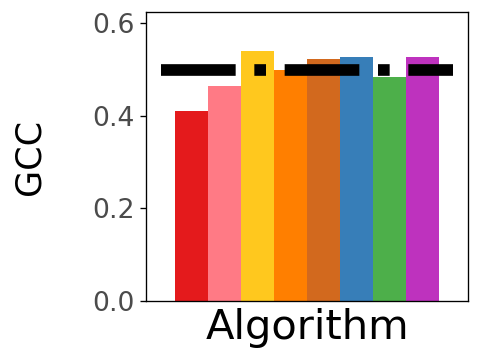

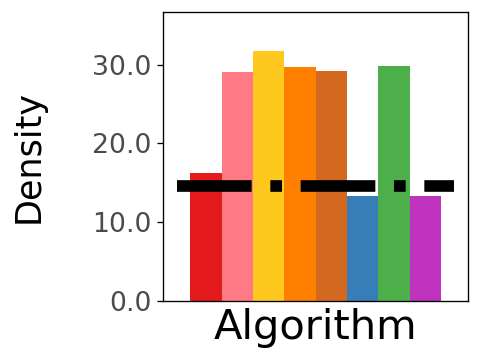

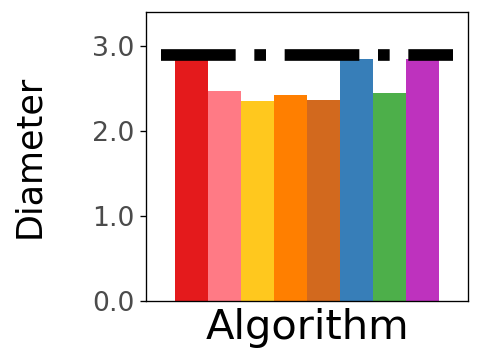

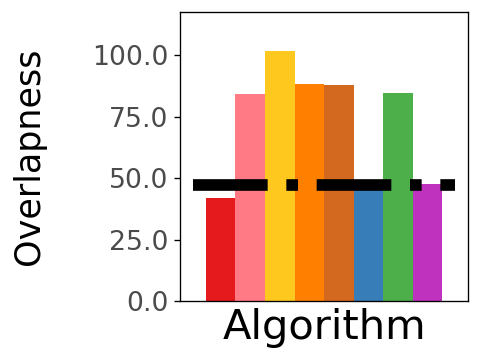

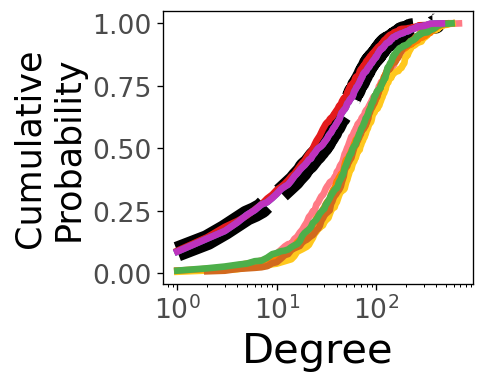

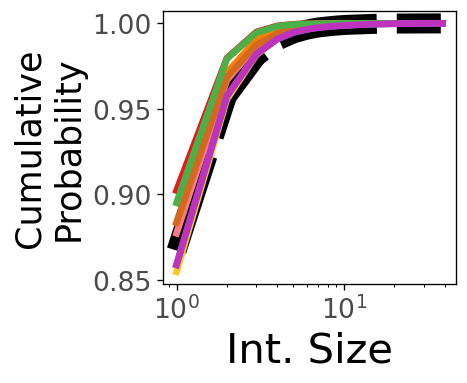

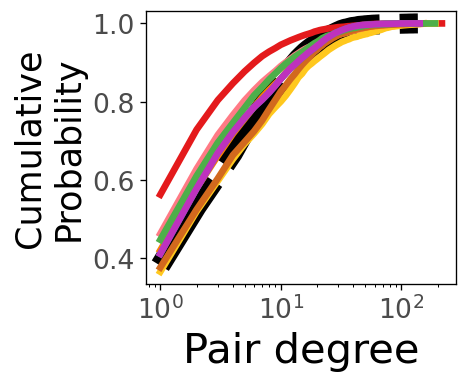

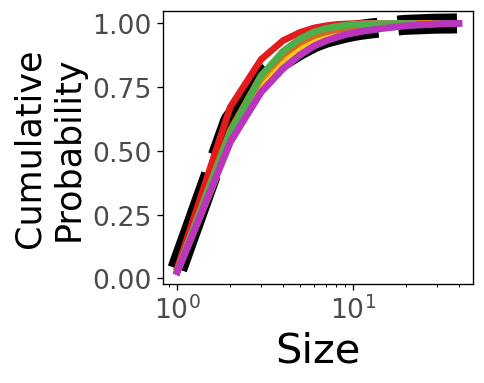

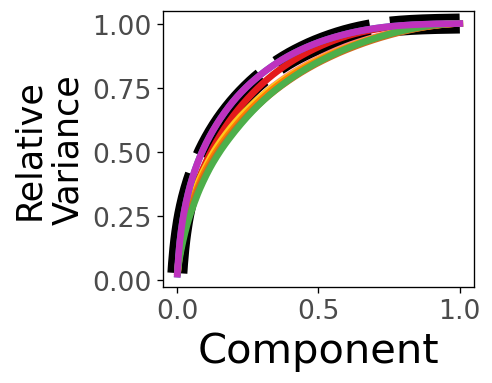

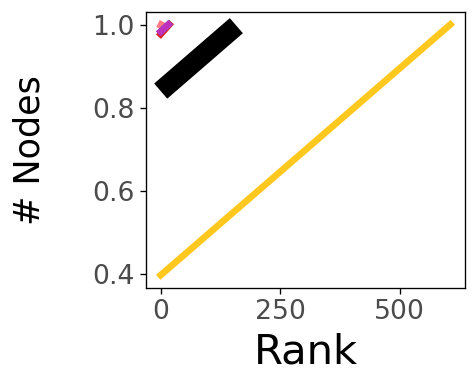

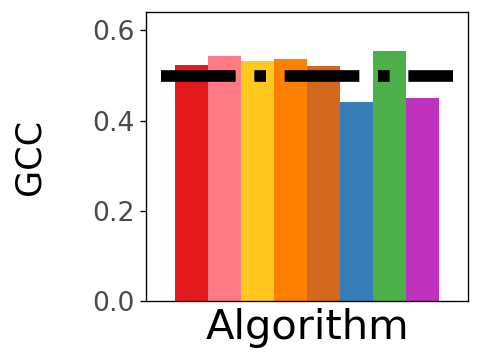

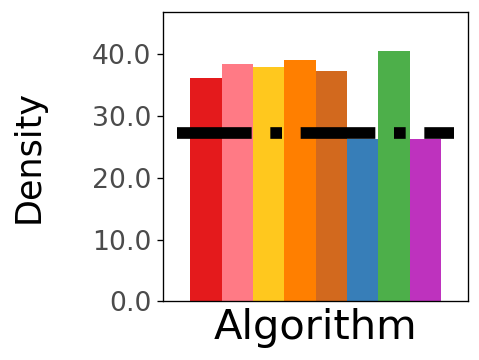

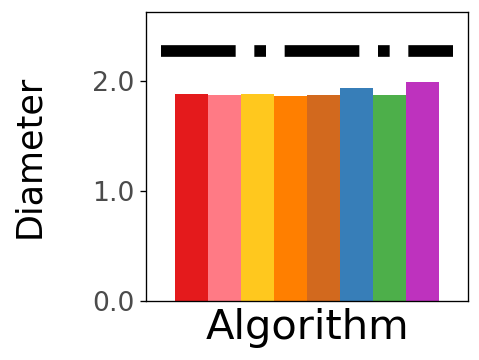

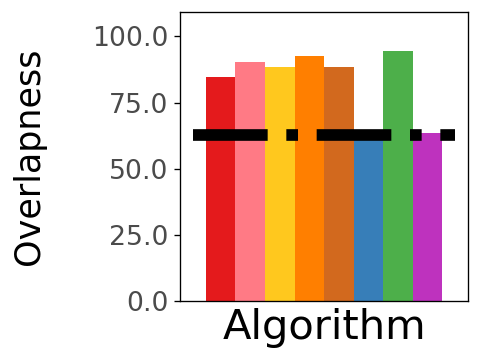

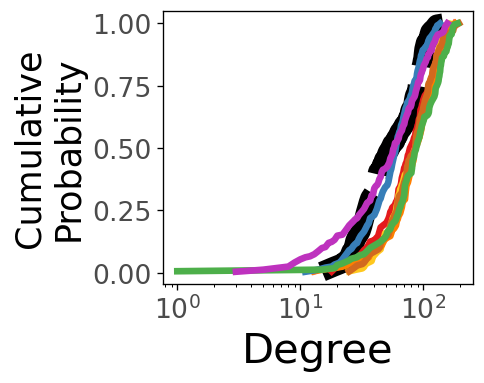

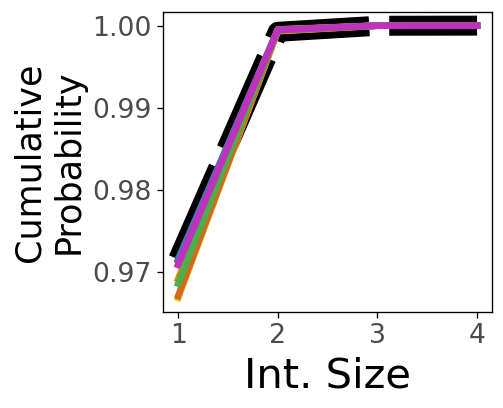

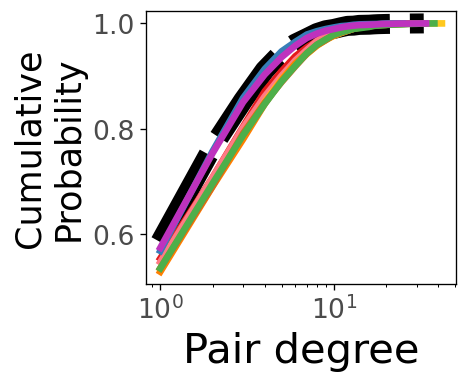

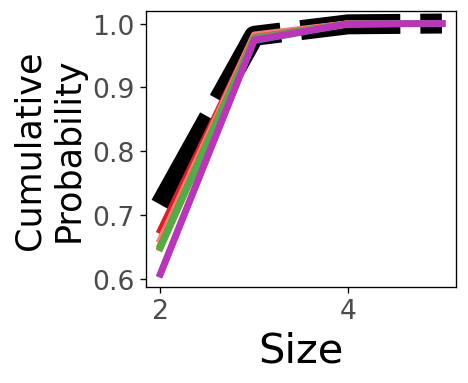

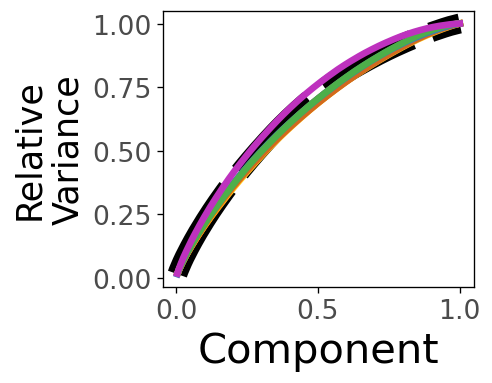

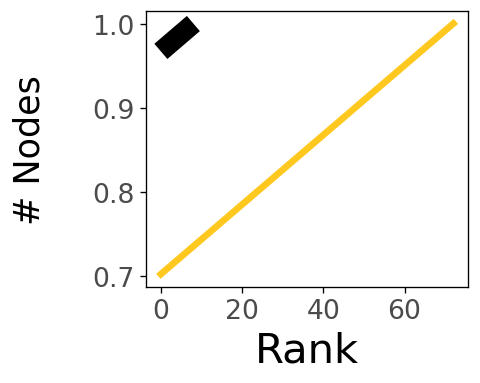

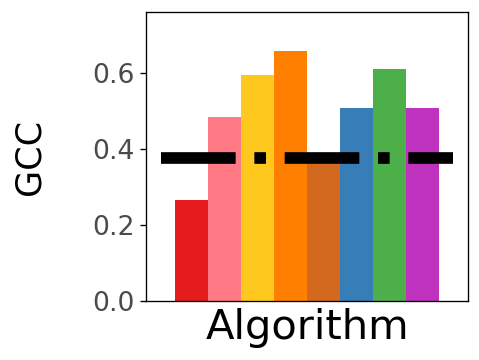

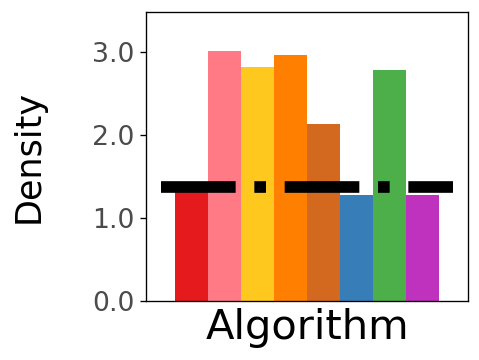

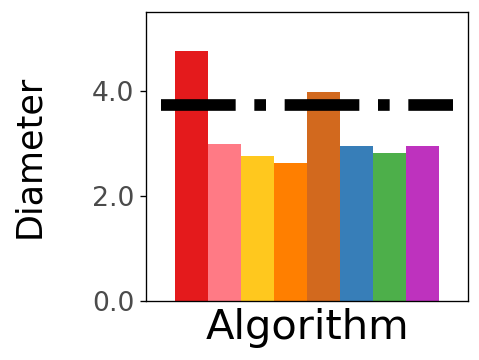

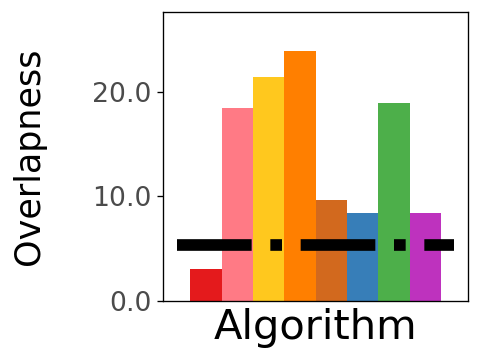

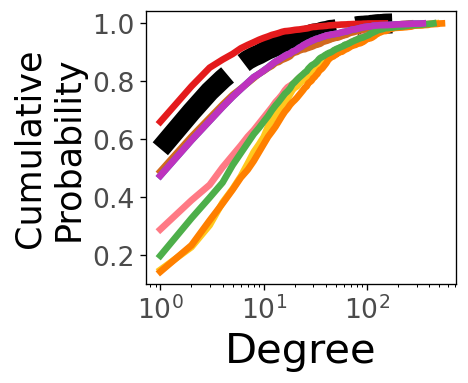

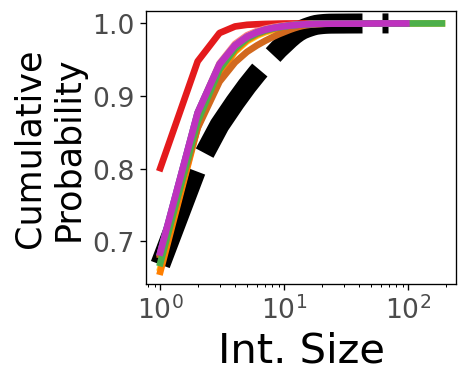

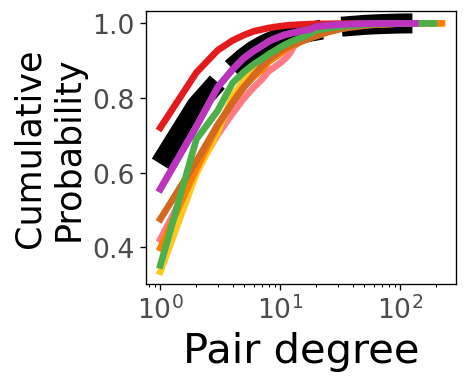

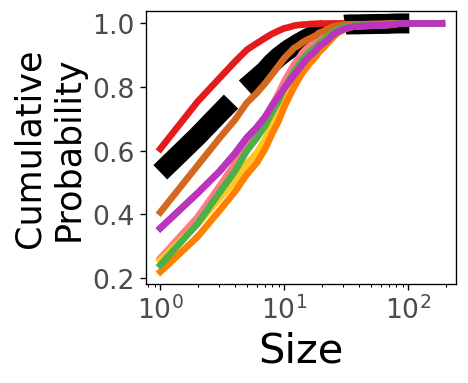

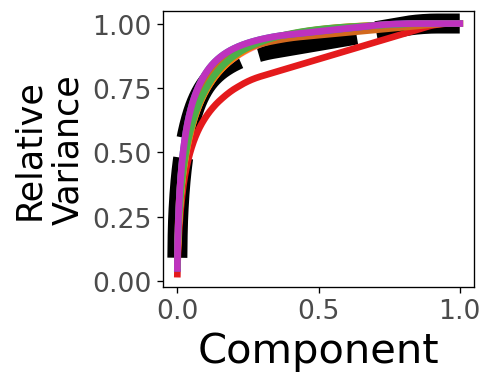

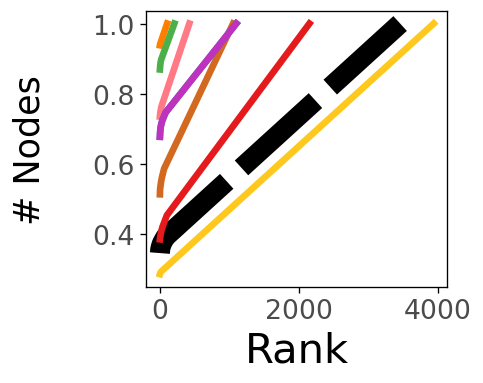

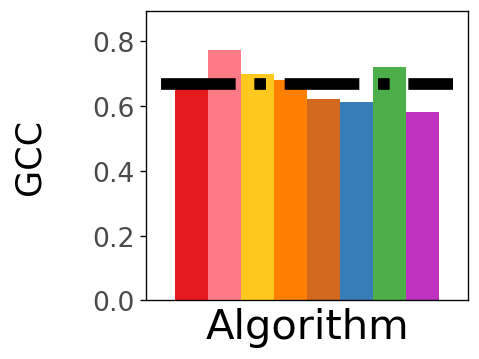

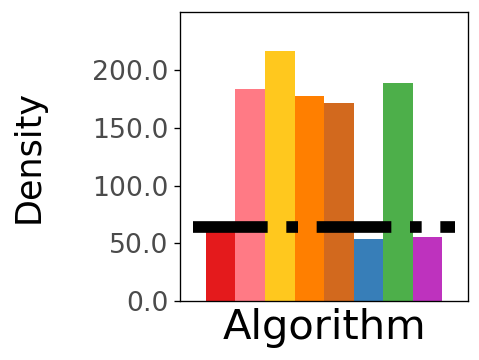

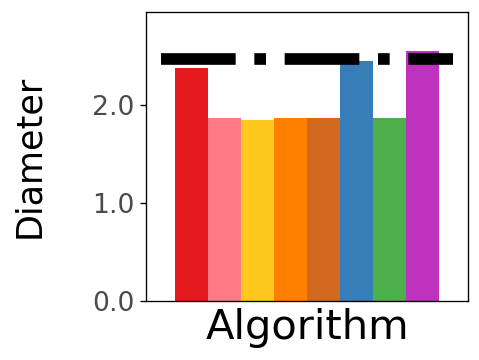

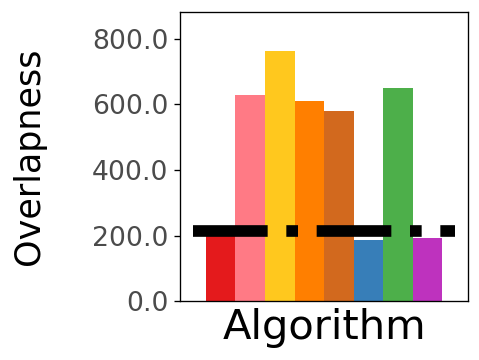

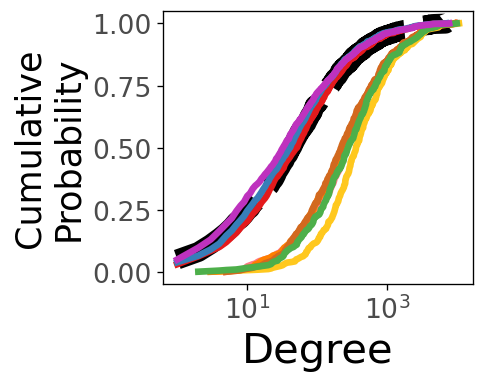

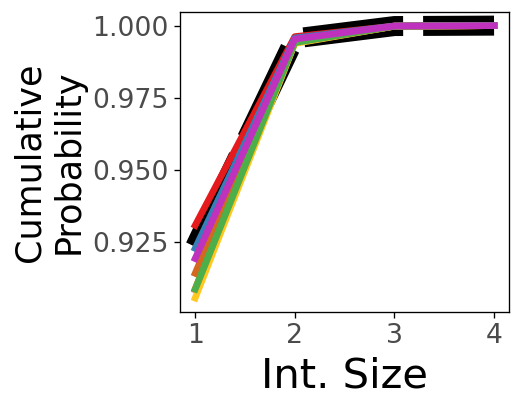

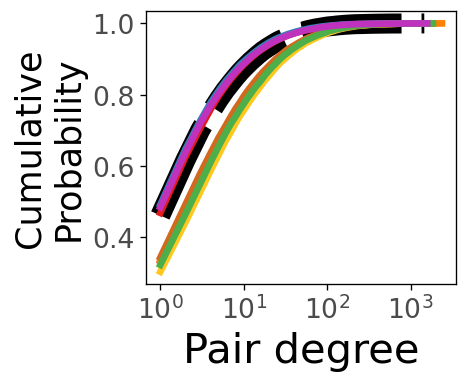

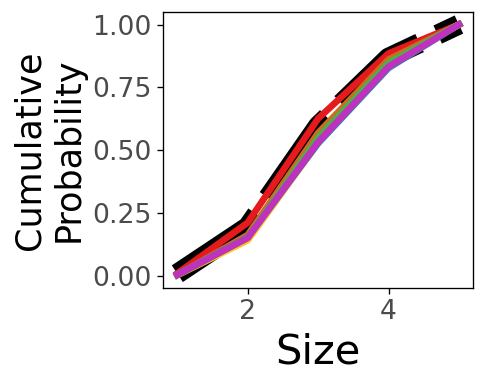

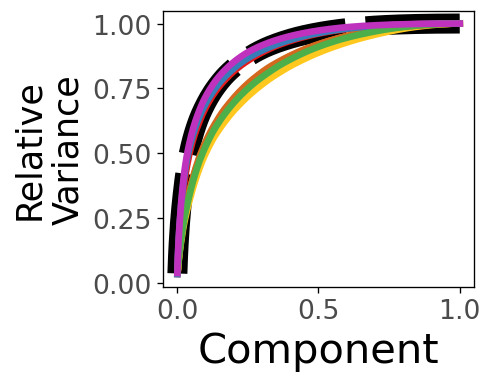

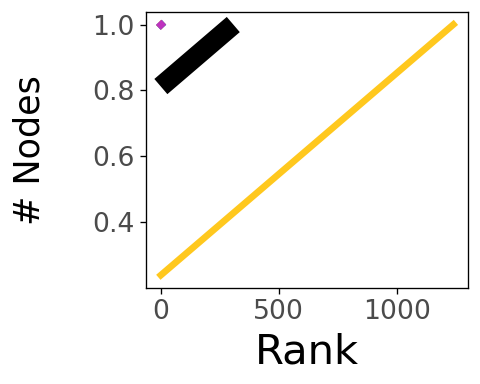

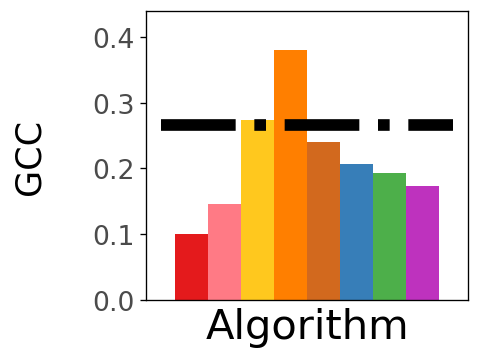

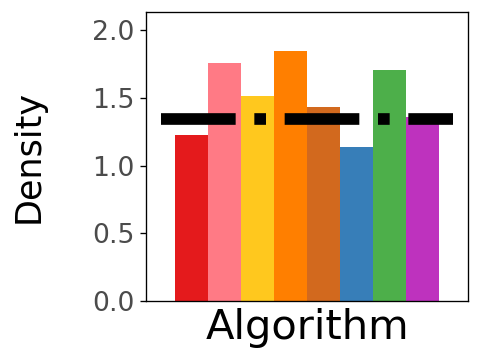

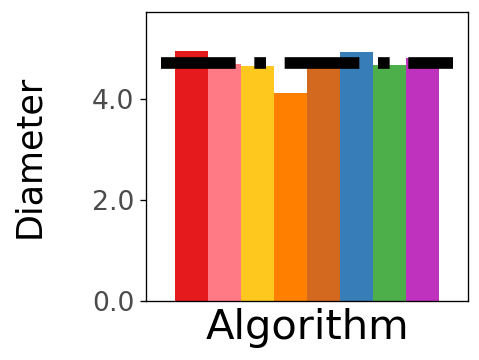

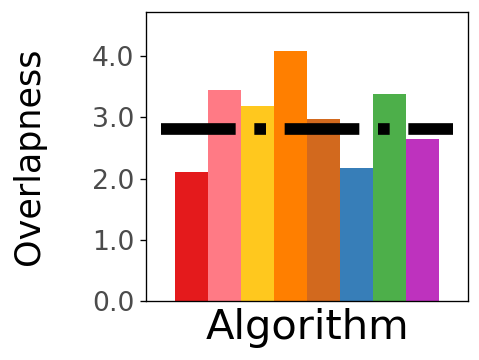

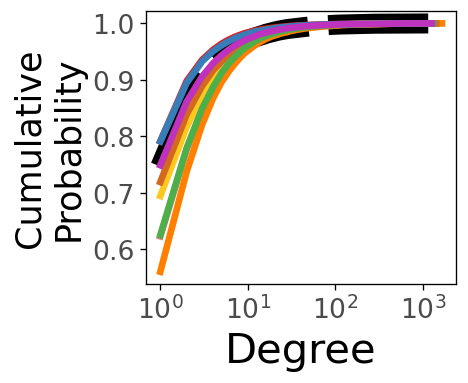

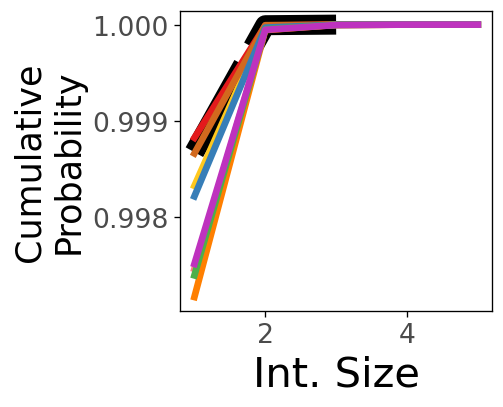

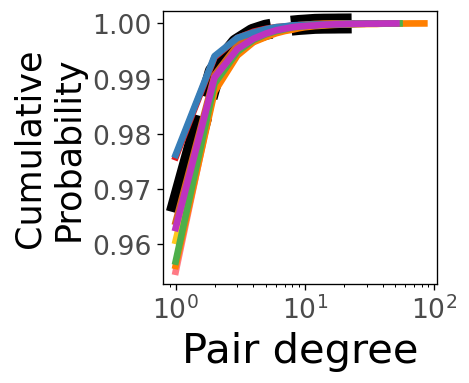

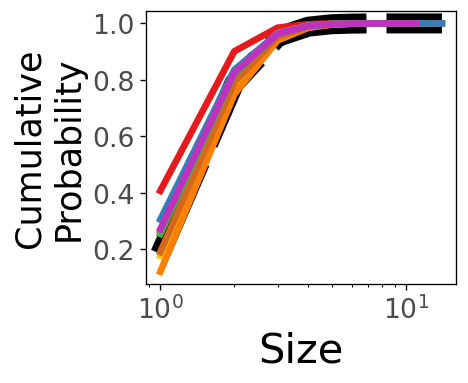

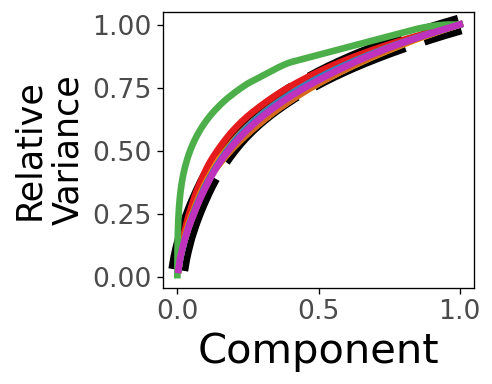

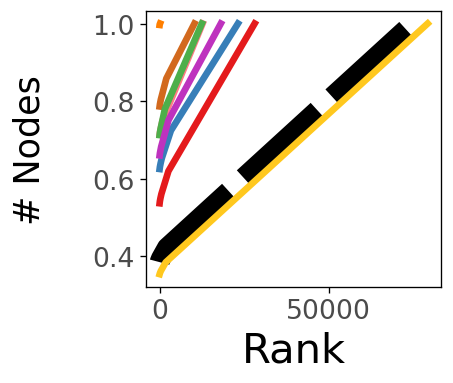

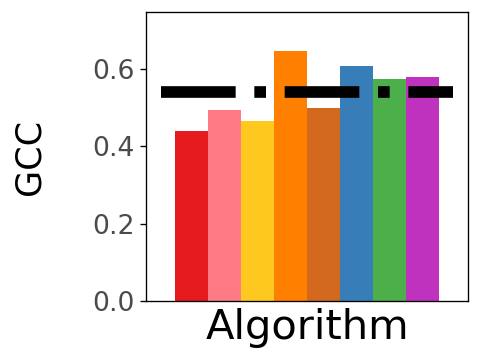

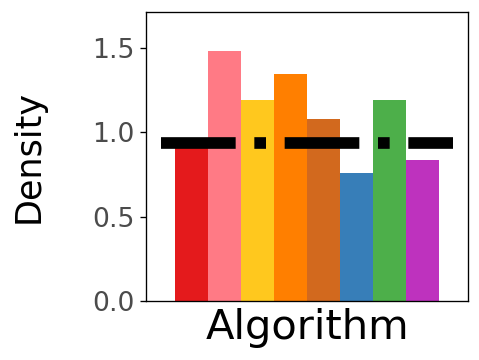

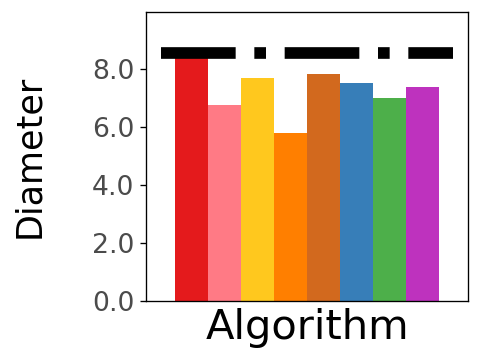

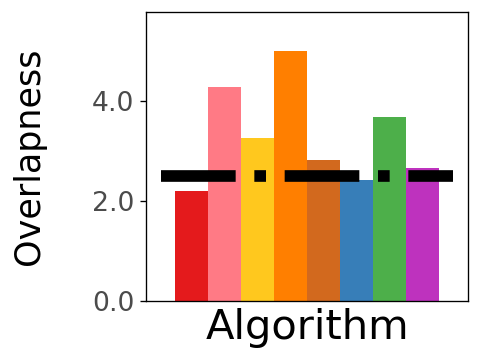

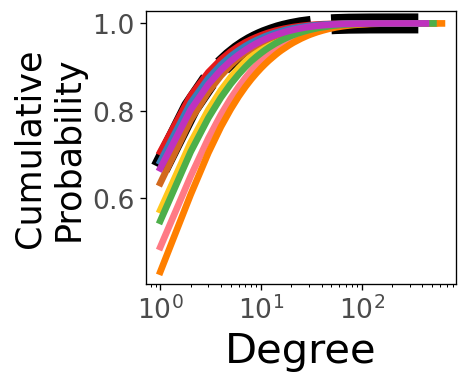

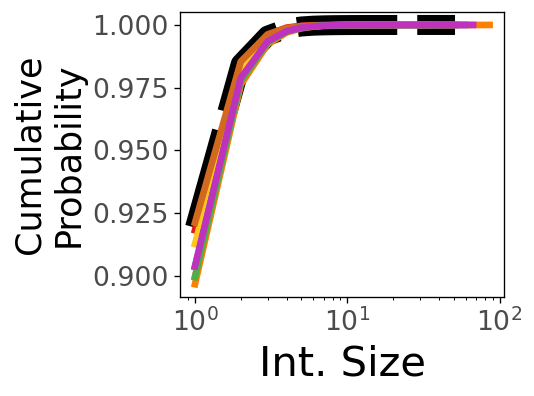

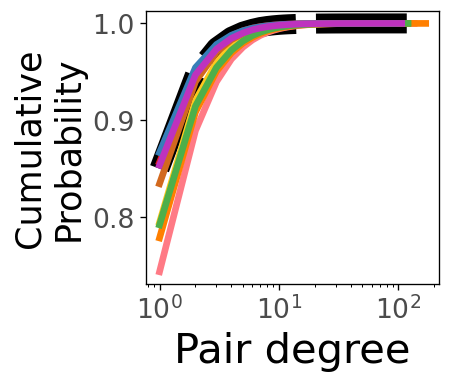

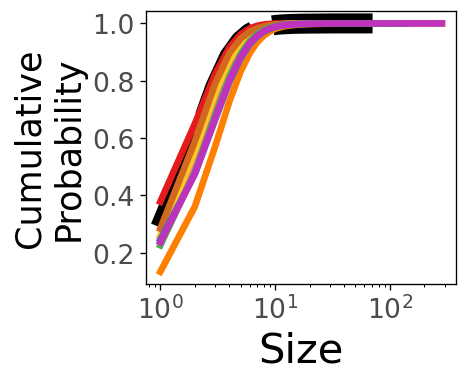

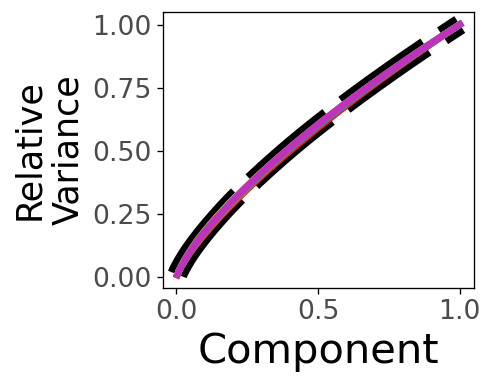

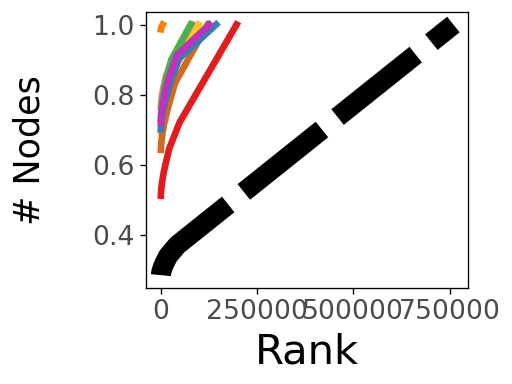

In [49]:
for dataname in dataset:
    dist = defaultdict(dict)
    # Make Dist
    dirpath = '../results/answer/{}/'.format(dataname)
    ret = get_dist(dirpath, portion)
    for e in ret.keys():
        dist["answer"][e] = ret[e]
    ret = get_value(dirpath, portion)
    for e in ret.keys():
        dist["answer"][e] = ret[e]
    for algoname in algonames:
        dirpath = '../results/{}/{}/{}/'.format(algoname, dataname, repeat)
        ret = get_dist(dirpath, portion)
        for e in ret.keys():
            dist[algoname][e] = ret[e]
        ret = get_value(dirpath, portion)
        for e in ret.keys():
            dist[algoname][e] = ret[e]

    for i, evalname in enumerate(evallist + evaldistlist):
        if evalname in ["clusteringcoef", "densification", "effdiameter", "overlapness"]:
            plt.figure(figsize=(4.4,3.4), dpi=120)
            # plt.figure(figsize=(4.3, 2.4), dpi=120)
        elif evalname in ["sv", "wcc"]:
            plt.figure(figsize=(4.4,3.6), dpi=120)
            # plt.figure(figsize=(4.3, 2.7), dpi=120)
#         elif evalname in ["intersection"]:
#             plt.figure(figsize=(4.4,3.6), dpi=120)
        elif evalname in ["intersection"]:
            if dataname in ["tags-math-sx", "threads-ask-ubuntu", "contact-primary-school"]:
                plt.figure(figsize=(4.6,3.8), dpi=120)
            elif dataname in ["coauth-MAG-Geology-full"]:
                plt.figure(figsize=(4.7,3.7), dpi=120)
            else:
                plt.figure(figsize=(4.3,3.6), dpi=120)
        else:
            plt.figure(figsize=(4.3,3.6), dpi=120)

        ret_answer = dist["answer"][evalname]
        if type(ret_answer) is dict:
            x = sorted(list(ret_answer.keys()))
            y = [ret_answer[_x] for _x in x]
            plt.plot(x, y, linewidth=12, linestyle=line_style_dict["answer"], label="ANSWER", alpha=1.0, c=color_dict["answer"]) #, marker=marker_dict[algo_name], markersize=4)        

        for j, algoname in enumerate(algonames):
            ret = dist[algoname][evalname]
            if type(ret) is dict:
                x = sorted(list(ret.keys()))
                y = [ret[_x] for _x in x]
                plt.plot(x, y, linewidth=4, linestyle=line_style_dict[algoname], label=rename[algoname], alpha=1.0, c=color_dict[algoname])
            else:
                plt.bar(rename[algoname], ret, label=rename[algoname], alpha=1.0, color=color_dict[algoname], align='center', width=1)

        ax = plt.gca()
        xmin, xmax = ax.get_xlim()
        if evalname in ["degree", "intersection", "pairdeg", "size"]:
            if xmax > 10:
                plt.xscale('log')
                locmaj = mpl.ticker.LogLocator(numticks=5)
                ax.xaxis.set_major_locator(locmaj)
        if evalname in ["clusteringcoef", "densification", "effdiameter", "overlapness"]:
            plt.hlines(y=ret_answer, xmin=xmin-0.02, xmax=xmax+0.02, linewidth=7, linestyle="dashdot", color='black', alpha=1.0)
            ymin, ymax = ax.get_ylim()
            plt.ylim(ymin, ymax*1.1)
            ax.set_xticks([])
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            plt.xlabel( "Algorithm", fontsize=25)

        else:
            plt.xlabel(labeldictx[evalname], fontsize=25)
        ax.tick_params(axis='y', which='major', labelcolor='#4B4B4B', labelsize=16)
        ax.tick_params(axis='x', which='minor', labelcolor='#4B4B4B',labelsize=14)
        ax.tick_params(axis='x', which='major', labelcolor='#4B4B4B', labelsize=16)

        plt.ylabel(labeldicty[evalname], fontsize=21)

        plt.tight_layout()
        if search_name == "final":
            savedir = "figures/Compete/"  + dataname + "/%.1f"% (portion) + "/"
        elif search_name == "baseline":
            savedir = "figures/Baseline/"  + dataname + "/%.1f"% (portion) + "/"
        savefname = savedir + "dist_" + evalname + ".jpg"
        if os.path.isdir(savedir) is False:
            os.makedirs(savedir)
        plt.savefig(savefname, bbox_inches='tight')
        plt.show()
        plt.close()